- C (float, default=1.0): 
    - Regularization parameter. 
    - The strength of the regularization is inversely proportional to C. 
    - Must be strictly positive. 
    - The penalty is a squared l2 penalty.
    - $λ = {1}/{C}$

- kernel ({‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’): 
    - Specifies the kernel type to be used in the algorithm. 
    - If none is given, ‘rbf’ will be used. 
    - If a callable is given it is used to pre-compute the kernel matrix from data matrices, <br>that matrix should be an array of shape ($n_{samples}, n_{samples}$).

- degree (int, default=3): Degree of the polynomial kernel function (‘poly’). 
    - Must be non-negative. 
    - Ignored by all other kernels.

- gamma ({‘scale’, ‘auto’} or float, default=’scale’): 
    - Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. 
    - if gamma='scale' (default) is passed then it uses $1 / {(n_{features} * X.var())}$ as value of gamma.
    - if ‘auto’, uses $1 / n_{features}$ as value of gamma.
    - if float, must be non-negative.

- coef0 (float, default=0.0):
    - Independent term in kernel function. 
    - It is only significant in ‘poly’ and ‘sigmoid’.

- max_iter (int, default=-1): 
    - Hard limit on iterations within solver, or -1 for no limit.

- random_state (int, RandomState instance or None, default=None):
    - Controls the pseudo random number generation for shuffling the data for probability estimates. 
    - Ignored when probability is False. 
    - Pass an int for reproducible output across multiple function.

- margin is the decision boundary
- alphas are the lagrange multipliers used to solve the double optimization problem

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class SVC:
    def __init__(self, C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, max_iter=1000):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.max_iter = max_iter

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.X = X
        self.y = y
        self.alphas = np.zeros(n_samples)
        self.b = 0
        if self.gamma == 'scale':
            self.gamma = 1 / (n_features * np.var(X))
        elif self.gamma == 'auto':
            self.gamma = 1 / n_features
        self.K = self._compute_kernel(X, X)

        for _ in range(self.max_iter):
            for i in range(n_samples):
                margin = y[i] * (np.dot(self.alphas * y, self.K[i]) + self.b)
                if margin < 1:
                    self.alphas[i] = min(self.alphas[i] + (1 - margin), self.C)
                else:
                    self.alphas[i] = max(0, self.alphas[i] - self.C * (self.alphas[i] > 1e-6))
            self.b = np.mean(y - np.dot(self.alphas * y, self.K))

    def _compute_kernel(self, X1, X2):
        if self.kernel == 'linear':
            return np.dot(X1, X2.T)
        elif self.kernel == 'poly':
            base = np.dot(X1, X2.T) + self.coef0
            return np.power(base, self.degree)
        elif self.kernel == 'rbf':
            X1_sq = np.sum(X1**2, axis=1).reshape(-1, 1)
            X2_sq = np.sum(X2**2, axis=1).reshape(1, -1)
            return np.exp(-self.gamma * (X1_sq + X2_sq - 2 * np.dot(X1, X2.T)))
        elif self.kernel == 'sigmoid':
            return np.tanh(self.gamma * np.dot(X1, X2.T) + self.coef0)
        else:
            raise ValueError("Unknown kernel")

    def decision_function(self, X):
        K = self._compute_kernel(X, self.X)
        return np.dot(K, self.alphas * self.y) + self.b

    def predict(self, X):
        return np.sign(self.decision_function(X))

## Testing the code on the iris dataset and plotting the decision boundaries for one vs two categories one by one

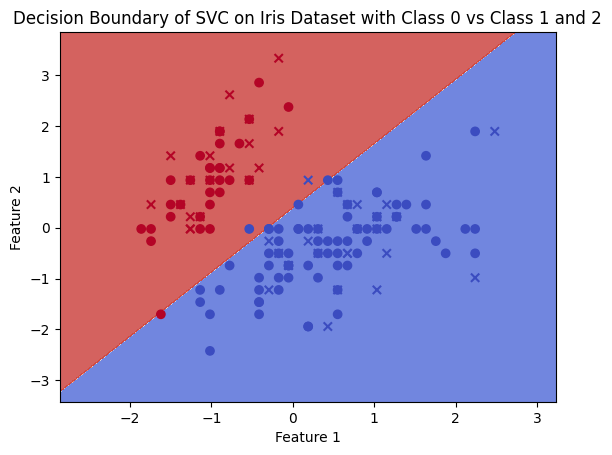

In [22]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

y_cache = np.unique(y)
# Convert to binary classification (class 0 vs. class 1 and 2)
y = np.where(y == 0, 1, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model0 = SVC(C=1.0, kernel='linear', max_iter=1000)
model0.fit(X_train, y_train)

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Z = model0.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='o')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, marker='x')
plt.title('Decision Boundary of SVC on Iris Dataset with Class 0 vs Class 1 and 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2');

In [23]:
from sklearn.metrics import accuracy_score

y_pred = model0.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


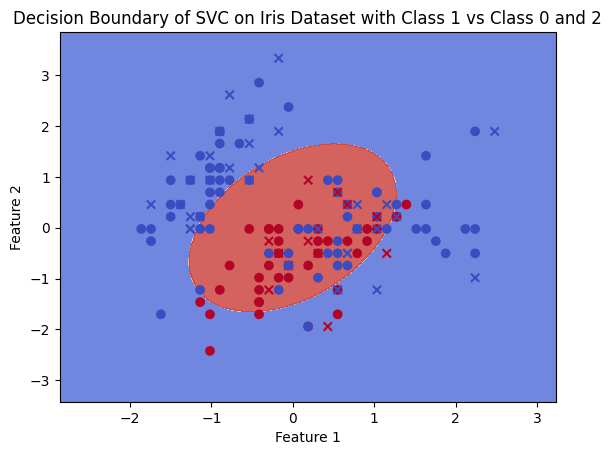

In [24]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

# Convert to binary classification (class 1 vs. class 0 and 2)
y = np.where(y == 1, 1, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model1 = SVC(C=0.1, kernel='poly',degree=2 , max_iter=1000)
model1.fit(X_train, y_train)

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Z = model1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='o')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, marker='x')
plt.title('Decision Boundary of SVC on Iris Dataset with Class 1 vs Class 0 and 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2');

In [25]:
from sklearn.metrics import accuracy_score

y_pred = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.73


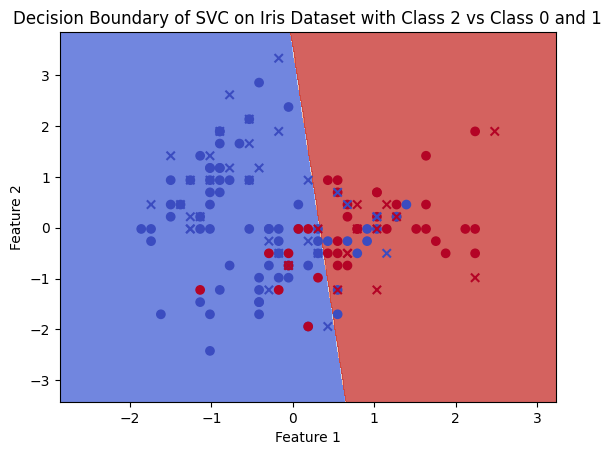

In [26]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

# Convert to binary classification (class 1 vs. class 0 and 1)
y = np.where(y == 2, 1, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model2 = SVC(C=0.1, kernel='linear', max_iter=1000)
model2.fit(X_train, y_train)

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Z = model2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='o')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, marker='x')
plt.title('Decision Boundary of SVC on Iris Dataset with Class 2 vs Class 0 and 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2');

In [27]:
from sklearn.metrics import accuracy_score

y_pred = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.84
